# Building a Numerical Solver From First Principles In Julia

In this notebook I build out a basic numerical solver using the forward and central finite difference methods in Julia. I then apply these methods to
1. The 1-D wave equation (physics).
2. The Hodgkin-Huxley model of the neuron (biology).
3. Black-Scholes equation (mathematical finance).

It is assumed that the reader has some familiarity with calculus and differential equations.

### I. Derivation of the Central and Forward Difference Equations
We start with the defintion of Taylor series, which can be used to approximate any function (that meets certain criteria) as a polynomial.

$$\sum_{n=0}^{\infty}\frac{f^{(n)}(a)}{n!}(x-a)^{n} \tag{1}$$

We use $eqn$ $1$ to expand a general function $f(x)$ and evaluate about $x_0$, for this case we only need to expand out to the second order term

$$f(x) \simeq f(x_0)+\frac{f'(x_0)(x - x_0)}{1!} + \frac{f''(x_0)(x - x_0)^2}{2!} \tag{2}$$

Likewise, we can expand $f(x+\Delta x)$, and evaluate at $x$ (one step back from $x + \Delta x$).

$$f(x+\Delta x) \simeq f(x)+\frac{f'(x)(x + \Delta x - x)}{1!} + \frac{f''(x)(x + \Delta x - x)^2}{2!} \tag{3}$$

Simplifying, we get:
$$f(x+\Delta x) \simeq f(x) + f'(x)(\Delta x) + \frac{f''(x)(\Delta x)^2}{2} \tag{4}$$

Similarly, we can solve for $f(x-\Delta x)$:
$$f(x-\Delta x) \simeq f(x) + f'(x)(-\Delta x) + \frac{f''(x)(-\Delta x)^2}{2} \tag{5}$$

Had we terminated at the first term and taken the same steps, we would arrive at:
$$f(x+\Delta x) \simeq f(x) + f'(x)(\Delta x) \tag{6}$$
$$f(x-\Delta x) \simeq f(x) + f'(x)(-\Delta x) \tag{7}$$

To compute what is known as the central difference method, we add $eqns$ $4$ and $5$ and solve for $f''(x)$:
$$f''(x) \simeq \frac{1}{\Delta x^2}[f(x+\Delta x) - 2f(x) + f(x-\Delta x)] \tag{8*}$$

Similarly, for the $f'(x)$ term (subtracting $eqns$ $6$ and $7$):
$$f'(x) \simeq \frac{1}{2\Delta x}[f(x+\Delta x) - f(x-\Delta x)] \tag{9*}$$

$Eqns$ $8$ and $9$ are known as the **central difference** equations [1]. 
Similarly we can obtain the **forward difference** equation directly from $Eqn$ $6$ for $f'(x)$.
$$f'(x) \simeq \frac{1}{\Delta x}[f(x+\Delta x) - f(x)] \tag{10*}$$
We'll use these to substitute (approximate) the differential terms in the differential equations that we'll encounter. You'll see later that whether forward or central differences is used depends on the use case.

### II. Approximating the 1D Wave Equation

The wave equation is a second order linear partial differential equation that describes the propagation of waves. The 1D wave equation is as follows:
$$\frac{\partial ^{2}u}{\partial t^{2}} = c^{2} \frac{\partial ^{2}u}{\partial x^{2}} \tag{11} ,$$
where c is the wave speed.

We'll see what happens if we say, pluck, a string at the center. But first let's derive our descritized wave equation. We'll be using the central difference $eqn$ $8$ above and plugging it into $eqn$ $11$, both for the time term $\frac{\partial ^{2}u}{\partial t^{2}}$ as well as the spacial term $\frac{\partial ^{2}u}{\partial x^{2}}$. *Note: For the time term just replace x in $eqn$ $8$ with t. Let's also replace f with u to match convention* [3].
$$\frac{1}{\Delta t^2}[u(t+\Delta t) - 2u(t) + u(t-\Delta t)] = c^{2}\frac{1}{\Delta x^2}[u(x+\Delta x) - 2u(x) + u(x-\Delta x)]$$
<br>
However, the above equation is incorrect, $eqn$ $8$ was derived for the one dimensional case. u is a function of both x and t, u(t,x), so let's make that adjustment.
<br><br>
$$\frac{1}{\Delta t^2}[u(t+\Delta t,x) - 2u(t,x) + u(t-\Delta t,x)] = c^{2}\frac{1}{\Delta x^2}[u(t,x+\Delta x) - 2u(t,x) + u(t,x-\Delta x)]$$
<br>
Because we'll be iterating over an array, using $\Delta x$ and $\Delta t$ doesn't make sense. Let's replace those with 1, indicating the next point in the array.
<br>
$$\frac{1}{\Delta t^2}[u(t+1,x) - 2u(t,x) + u(t-1,x)] = c^{2}\frac{1}{\Delta x^2}[u(t,x+1) - 2u(t,x) + u(t,x-1)]$$
<br>
We can then solve for u(t+1,x):
<br>
$$u(t+1,x) = \frac{c^2 \cdot \Delta t^2}{Δx^2} \cdot [u(t,x+1)-2 \cdot u(t,x)+u(t,x-1)] + 2 \cdot u(t, x) - u(t-1, x) \tag{12*}$$

We can then use $eqn$ $11$ in the following fashion:
1. Fill in the boundaries of our mesh.
2. Iterate through time t.
3. for each time t, iterate over each x.

You may notice that we are solving for t+1 (rather than t), so this requires that we already know something about our system at t. We get this information from our **boundary conditions** and **initial conditions**. Specifically for central differences, we'll need to know the first two timesteps of our mesh. See the diagram below for a visual aid for how we iterate over each t and x. We solve for the point circled in red, using the four points that are transparently circled. As an exercise, see if you can relate each point cirlced point in the diagram to its respective term in $eqn$ $12$. To get you started, the red point (what we are solving for) is on the left hand side of the equation.

<img src="solver_central_diff.png" alt="1d_wave_mesh" style="width: 900px;"/>
<div style="text-align: right">Adaptation of figure in [3].</div>

You might have noticed that the steps above requires that we already known the first two time steps. We get the first time step from the boundary condition, and we can get the second from the initial condition $\frac{\partial u(t=0,x)}{\partial t} = 0$, plugging this into $Eqn$ $9$, we get $u(t+1,x) = u(t-1,x)$ which we then subsitute into $Eqn$ $12$ yielding
$$u(1,x) = \frac{c^2 \cdot \Delta t^2}{2 Δx^2} \cdot [u(0,x+1)-2 \cdot u(0,x)+u(0,x-1)] + 2 \cdot u(0, x) \tag{13*}$$

Combining our boundary conditions, initial condition, and $Eqns$ $12$ and $13$ we can finally solve the wave equation. I'll be applying the initial condition of the form $e^{-x^2}$ to simulate the plucking of a string at the center.

In [98]:
# Variable set-up
T = 20                               # Duration of time
L = 200                              # Length of string
n_t = 100 + 1                        # Number of time steps
n_x = 200 + 1                        # Number of length steps
ts = range(0, T; length=n_t)         # Used for plotting
xs = range(-L/2, L/2; length=n_x)    # Used for plotting
Δt = ts[2] - ts[1]                   # Time step
Δx = xs[2] - xs[1]                   # Length step
c = 4                                # Speed of the wave
C = c*(Δt/Δx)                        # Courant number, this should at or below 1 for stable solutions

0.8

In [99]:
# Initialize an array with all zeros (which will get replaced with the solution u)
u = zeros(n_t, n_x)

# Define our intial condition function ("plucking" the string)
f(t,x) = 200*exp(-((x-100)/5)^2)

f (generic function with 1 method)

In [100]:
# Set initial condition
for x in 2:n_x-1
    u[1,x] = f(1,x)
end

# Set 2nd time step (Eqn 12)
for x in 2:n_x-1
    u[2,x] = u[1, x] + 0.5 * (c^2*(Δt/Δx))^2 * (u[1, x+1] - 2*u[1, x] + u[1, x-1]) #+ dirac_delta(x, L/2+1) # + or - ??
end

# Calculate the solutions for the rest of the timesteps
for t in 2:n_t-1, x in 2:n_x-1
    u[t+1, x] = c^2 * Δt^2 * ((u[t, x+1] - 2*u[t, x] + u[t, x-1])/Δx^2) + 2*u[t, x] - u[t-1, x]
end

Plots.AnimatedGif("G:\\My Drive\\Projects\\Numerical Solver\\wave_bns___.gif")
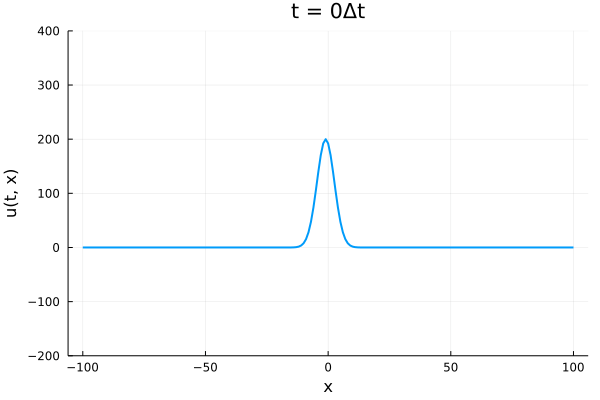

In [102]:
using Plots

anim = @animate for (i, row) in enumerate(eachrow(u))
    plot(
        xs,
        row;
        title = "t = $(i-1)Δt",
        xlabel = "x",
        ylabel = "u(t, x)",
        legend = false,
        linewidth = 2,
        ylims=(-200,400)
    )
end
gif(anim, "wave_bns.gif"; show_msg = false)

### II. Hodgkin Huxley Model of the Neuron

Neurons are the cells responsible for sending electrical (electrochemical) signals throughout the body, allowing everything from motor function, sight, hearing, thinking, etc. (pretty much everything you do). Neurons achieve this through an exitatory process called the action potential. The result of this could trigger more neurons to fire, such as in a nerve, or could be to release a hormone, such as in neuroendocrine cells.
<br><br>
Cells naturally maintain a separation of charge between the inside and outside of the cell, net-positive on the exterior and net-negative on the interior. This separation of charge is also known as a potential difference. At the cell's resting state this is known as the resting or steady-state membrane potential **Vss_m**.
<br><br>
In nuerons, this membrane potential changes in response to a stimulus causing a cascading event down the length of the neuron. For example, a stimulus such as someone poking you, causes the sodium (**Na**) gates in mechanorecepting neurons in your skin to open, allowing a mass influx of Na ions into the cell. The cell then wants to approach the steady-state membrane voltage for Na (**Vss_Na**), but as the cell approaches this new steady-state, potassium (**K**) channels open causing a mass outflux of potassium ions out of the cell. Similarly, the cell now tries to reach the steady-state membrane voltage for K (**Vss_K**), but before doing so closes the potassium gates. The cell now resets to its resting membrane potential (**Vss_m**) to repeat the process if the stimulus still exists. Alan Hodgkin and Andrew Huxley were able to develop a system of of nonlinear differential equations to describe this process! Below are some figures showing the **n-gate** (corresponding to the K channel), and the **m and h gates** (corresponding to the Na channel) and at what points they open and close during the action potential.

<img src="AP_image.png" alt="Potassium" style="width: 800px;"/>
<div style="text-align: right">Adaptations of figures [5][6].</div>

To describe this phenomenon, Hodgkin and Huxley came up with the set of differential equations:
$$C_{m}\frac{\partial V_{m}}{\partial t} = \bar{g}_{L}(V_{SS_{m}}-V_{m}) + \bar{g}_{Na}m^{3}h(V_{SS_{Na}}-V_{m}) + \bar{g}_{K}n^{4}(V_{SS_{K}}-V_{m}) + I_{m} \tag{14.1} $$
$$\frac{\partial m}{\partial t} = \alpha_{m}(1-m)-\beta_{m}m \tag{14.2} $$
$$\frac{\partial h}{\partial t} = \alpha_{h}(1-h)-\beta_{h}h \tag{14.3} $$
$$\frac{\partial n}{\partial t} = \alpha_{n}(1-n)-\beta_{n}n \tag{14.4} $$
Where $\alpha_{n},\alpha_{m},\alpha_{h},\beta_{n},\beta_{m},\beta_{h}$ were experimentally derived by Hodgkin and Huxley and are defined below.
$$\alpha_{n} = \frac{0.01 \cdot (10-(V_{m}-V_{SS_{m}}))}{exp(\frac{10-(V_{m}-V_{SS_{m}})}{10})-1}$$
$$\alpha_{m} = \frac{0.1 \cdot (25-(V_{m}-V_{SS_{m}}))}{exp(\frac{25-(V_{m}-V_{SS_{m}})}{10})-1}$$
$$\alpha_{h} = 0.07 \cdot exp \left( \frac{-(V_{m}-V_{SS_{m}})}{20} \right)$$
$$\beta_{n} = 0.125 \cdot exp \left( \frac{-(V_{m}-V_{SS_{m}})}{80} \right)$$
$$\beta_{m} = 4 \cdot exp \left( \frac{-(V_{m}-V_{SS_{m}})}{18} \right)$$
$$\beta_{h} = \frac{1}{exp \left( \frac{30-(V_{m}-V_{SS_{m}})}{10} \right) +1}$$
Notice that $V_{m}$ is dependent on **m**,**h**, and **n** and vice versa. As we iterate through time, **m**,**h**, and **n** will need to be solved for using the previous timestep value for $V_{m}$ before we can solve for the current timestep value for $V_{m}$.

Now to create our descritized equations, for this we'll need to use the *forward difference*. We'll plug in $Eqn$ $10$ into $Eqn$ $14.1$. *Note: I tried central differences first, but it kept producing results that shot to infinity. I later found out that forward differences is usually used here. I'll include an image at the bottom of what I was seeing.*

$$V(t+1) = V(t) + \Delta t \left[ \bar{g}_{L}(V_{SS_{m}}-V(t)) + \bar{g}_{Na} \cdot m(t+1)^{3} \cdot h(t+1) \cdot (V_{SS_{Na}}-V(t)) + \bar{g}_{K} \cdot n(t+1)^{4} \cdot (V_{SS_{K}}-V(t)) + I_{m} \right] \tag{15.1} $$
$$m(t+1) = \Delta t(\alpha_{m}-(\alpha_{m}+\beta_{m}) \cdot m(t)) + m(t) \tag{15.2}$$
$$h(t+1) = \Delta t(\alpha_{h}-(\alpha_{h}+\beta_{h}) \cdot h(t)) + h(t) \tag{15.3}$$
$$n(t+1) = \Delta t(\alpha_{n}-(\alpha_{n}+\beta_{n}) \cdot n(t)) + n(t) \tag{15.4}$$
Now let's solve for the equations above and observe the dependency of these equations on each other.

In [45]:
# Define our variables
T = 30                               # Duration of simulation in ms
n_t = 10000                          # Number of timesteps
ts = range(0, T; length=n_t)         # Used for plotting
Δt = ts[2] - ts[1]                   # Timestep
Vss_m = -70                          # Resting cell membrane potential (mV)
Vss_Na = 58.1                        # Steady state for Sodium (mV)
Vss_K = -80                          # Steady state for Potassium (mV)
c_m = 1                              # Membrane Capacitance μF/cm^2
ḡ_Na = 120                           # Conductance per unit area for sodium mS/cm^2 
ḡ_K = 36                             # Conductance per unit area for potassium mS/cm^2 
ḡ_l = 0.9                            # Conductance per unit area for passive membrane mS/cm^2 
;

In [46]:
# Stimulation to trigger action potential(s)
function I(time_input)
    #t = time_input*delta_t
    if time_input in 1500:3000
        return 10
    else
        return 0
    end
end
I_p = I.(1:n_t);

In [47]:
# Create empty arrays
v = zeros(n_t)
n = zeros(n_t)
m = zeros(n_t)
h = zeros(n_t);

In [48]:
# Set initial conditions
v[1] = Vss_m
α_n = (0.01*(10-(v[1]-Vss_m)))/(exp((10-(v[1]-Vss_m))/10)-1)
α_m = (0.1*(25-(v[1]-Vss_m)))/(exp((25-(v[1]-Vss_m))/10)-1)
α_h = 0.07*exp((-(v[1]-Vss_m))/20)
β_n = 0.125*exp((-(v[1]-Vss_m))/80)
β_m = 4*exp((-(v[1]-Vss_m))/18)
β_h = (1)/(exp((30-(v[1]-Vss_m))/10)+1)
n[1] = (α_n/(α_n+β_n))
m[1] = (α_m/(α_m+β_m))
h[1] = (α_h/(α_h+β_h))
n[2] = (α_n/(α_n+β_n))
m[2] = (α_m/(α_m+β_m))
h[2] = (α_h/(α_h+β_h))

# Calc 1:n_t
for t in 1:n_t-1
    α_n = (0.01*(10-(v[t]-Vss_m)))/(exp((10-(v[t]-Vss_m))/10)-1)
    α_m = (0.1*(25-(v[t]-Vss_m)))/(exp((25-(v[t]-Vss_m))/10)-1)
    α_h = 0.07*exp((-(v[t]-Vss_m))/20)
    β_n = 0.125*exp((-(v[t]-Vss_m))/80)
    β_m = 4*exp((-(v[t]-Vss_m))/18)
    β_h = (1)/(exp((30-(v[t]-Vss_m))/10)+1)
    
    n[t+1] = Δt*(α_n - (α_n+β_n)*n[t]) + n[t]
    m[t+1] = Δt*(α_m - (α_m+β_m)*m[t]) + m[t]
    h[t+1] = Δt*(α_h - (α_h+β_h)*h[t]) + h[t]
    
    v[t+1] = v[t] + (Δt*ḡ_l*(Vss_m-v[t]) + Δt*ḡ_Na*(m[t+1]^3)*h[t+1]*(Vss_Na-v[t]) + Δt*ḡ_K*(n[t+1]^4)*(Vss_K-v[t]) + Δt*I(t))
end

Plots.AnimatedGif("G:\\My Drive\\Projects\\Numerical Solver\\action_potential_bns.gif")
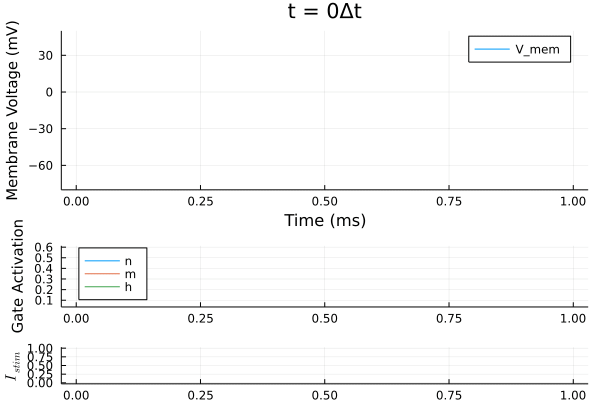

In [49]:
using Plots
l = @layout [a{0.65h} ; b{0.25h}; c{0.15h}]
anim = @animate for i in eachindex(v)
    p1 = plot(
            ts[1:i],
            v[1:i],
            title = "t = $(i-1)Δt",
            xlabel = "Time (ms)",
            ylabel = "Membrane Voltage (mV)",
            yguidefontsize=10,
            ylims=(-80,50),
            label="V_mem";
        )
    p2 = plot(ts[1:i], [n[1:i],m[1:i],h[1:i]], label=["n" "m" "h"], ylabel = "Gate Activation", yguidefontsize=10, legend=:topleft)
    p3 = plot(ts[1:i], I_p[1:i], ylabel = "\$I_{stim}\$", yguidefontsize=10, legend=nothing)
    plot(p1, p2, p3, layout = l)
end every 25
gif(anim,"action_potential_bns.gif", show_msg = false)


If we increase the stimulus intensity and duration, we can even get multiple sequential action potentials! Notice how they decrease in amplitude. I'll leave it to the reader to change the parameters and give it a try!

<img src="action_potential_multiple_bns.gif" alt="multiple" style="width: 600px;"/>

### II. Black-Scholes Model

The Black-Scholes model is heavily used in mathematical finance to value options. I'll give the technical definition of an option from (source) because I am definitely **not** an expert in this field:
<br><br>
*A financial option is a contract between two parties, the holder and the writer, which gives the holder the right, but not the obligation, to buy from or sell to the writer a given underlying asset at a prescribed price on or before a prescribed time* [8]. 
<br><br>
So basically an option is a way to spread risk among multiple parties. A very simple example of an option would be something like car insurance, in this case you pay a *premium* which gives you the right, but not the obligation, to exercise the option in the event that you need it. If your car is in need of repairs, the insurance company will pay for the cost of the repairs. The insurance company hedges this risk by offering similar options to many customers, where most people won't need to exercise the option. If someone is deemed riskier, then they pay a higher premium. 
<br><br>
Likewise, something similar is done with assets like stocks and commodities. Writers will create contracts that give traders the option of buying or selling an asset at a prescribed price and expiration date. The holder will pay the writer a premium to purchase the option. If the holder thinks the asset will increase in price then the holder purchases a call option. If the holder thinks the price of the asset will go down, then the holder purchases a put option. For example with a call option, if the holder buys an option for a stock at \\$10 per share (the **exercise**, or **strike** price), and the price later goes up to \\$15, the holder can exercise the option (purchase the stock at \\$10 per share) and earn a profit of \\$5 per share, minus the premium cost. If the holder guessed incorrectly (and the stock decreased), they only lose the cost of the premium.
<br><br>
So how does the writer in this case value the option? The Black-Scholes partial differential equation!
<br><br>
*Note: I'll be using the version for European stock options for this. There are some variations depending on the use case, such as American stock options, and Two-asset options.*

The Black-Scholes equation is as follows:
$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2} \frac{\partial^{2} V}{\partial S^{2}} + rS \frac{\partial V}{\partial S} - rV = 0 \tag{16}$$

Where **V** is the value of the option at time **t**, $\sigma$ is the standard deviation of logarithmic returns (volatility), **r** is the risk free interest rate, and **S** is the price of the asset.
<br>
Let's proceed as before and create our descritized equation. Again, I tried using central differences for all the differentials but I could not get it to work (It would have required us making an assumption for the inital condition as we did with the wave equation in part 1 above). So I defaulted to the standard practice of using forward differences for the first order time term $\frac{\partial V}{\partial t}$ and central differences for the price S terms ($\frac{\partial^{2} V}{\partial S^{2}}$ and $\frac{\partial V}{\partial S}$) [9].
<br>
Let's plug $Eqns$ $8$, $9$ and $10$:

$$V(s,t+1) = \Delta t \left[-\frac{\sigma ^{2}S^{2}}{2\Delta s^{2}}[V(s+1,t) - 2V(s,t) + V(s-1,t)] - \frac{rS}{2\Delta s}[V(s+1,t) - V(s-1,t)] + rV(s,t) \right] + V(s,t) \tag{17}$$

**Example problem:** Say the price of an asset is currently trading at \\$98 and you believe that the price will go up to somewhere around \\$110 in one month. You want to minimize the risk that you are exposed to in the event that the asset does not go up (spread the risk). What should the writer of the option charge you (in exchange for taking on this risk)? The risk free interest rate is 5% and the volatility is 25%. The strike price is set at \\$100.

In [74]:
# Define our variables
T = 1*(1/12)                               # Duration of option (in years)
n_t = 1600                                 # Number of timesteps
ts = range(0, T; length=n_t)               # Used for plotting
Δt = ts[2] - ts[1]                         # Timestep
Smax = 300                                 # Max asset price to calculate for (generally 3-4 times the strike price [9])
n_s = 160                                  # Number of asset price steps
ss = range(1, Smax; length=n_s)            # Used for plotting
Δs = ss[2] - ss[1]                         # Asset price step
E = 100                                    # Option exercise or strike price
r = 0.05                                   # Risk free interest rate
σ = 0.25                                   # Volatility of the asset (standard deviation of logarithmic returns)
((σ^2)*(Smax^2)*Δt)/(Δs)^2                 # This should be less than or equal to (or not much more than) 1 for stable solutions

0.08289812142029379

*Note: You could even have a volatility that changes with price (rather than being constant). As an example:
σ(s) = -0.0009s + 0.0499 
and then use σ(s\*Δs) instead of σ in the code below.
I had calculated the above σ(s) for Bitcoin before realizing it didn't make sense to use it in this context. I might try this in the future though.*

In [75]:
# Initialize our mesh
v = zeros(n_s,n_t);

In [76]:
# Set initial condition (Profit function - we know what the profit would be at the end of the option at various prices)
for s in 1:n_s
    v[s,1] = max(s*Δs-E,0)
end

# Set boundary conditions
for t in 1:n_t
    v[1,t] = 0
    v[n_s,t] = Smax - E*exp(-r*t*Δt)
end

# Note: S = s*Δs
for t in 1:n_t-1, s in 2:n_s-1
    v[s,t+1] = Δt*((1/2)*(σ^2)*((s^2)*Δs^2)*(1/(Δs^2))*(v[s+1,t] - 2*v[s,t] + v[s-1,t]) + r*(s*Δs)*(1/(2*Δs))*(v[s+1,t] - v[s-1,t]) - r*v[s,t]) + v[s,t]
end

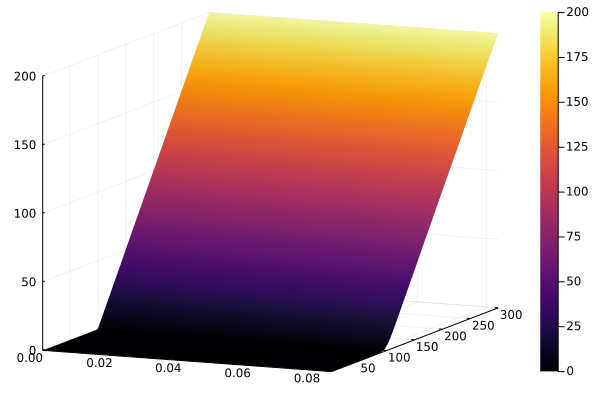

In [77]:
using Plots
surface(ts,ss,v;) # zlims=(-10,100000) zlims=(-5,25), camera = (50, 30)

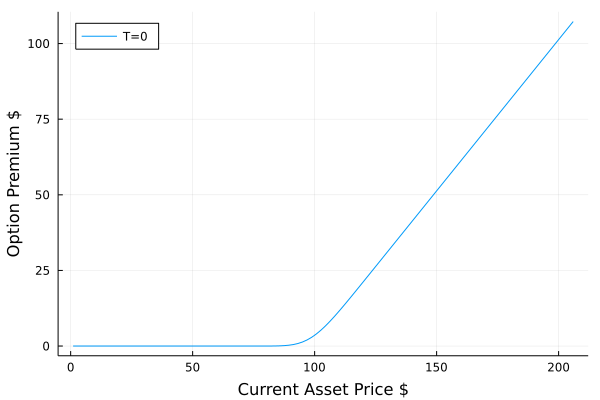

In [94]:
using Plots
plot(ss[1:110],v[1:110,end]; xlabel="Current Asset Price \$\$", ylabel="Option Premium \$\$", legend=:topleft, label="T=0")

In [96]:
# Find option value at S = $98
v[findall(x->floor(x)==98, ss),end]

1-element Vector{Float64}:
 2.898911174403307

With the asset current trading at \\$98, the writer would charge \\$2.89 per share for the option. Let's say you purchased 100 shares. If the price goes up to \\$110 as predicted, the profit you would take would be (\\$110-\\$100) * 100 shares - \\$2.89 * 100 = 1000 - 289 = **\\$711**.
<br><br>
Had you not purchased the option and purchased the asset you could have made the full \\$1000, but you would have taken the full risk. Had the asset price fallen to, say, \\$90 and you would be at a loss of \\$1000. The option here works as a form of insurance that minimizes your risk, therefore you would only lose \\$289.

### References

1. Farlow, Stanley J. Partial differential equations for scientists and engineers. Courier Corporation, 1993.
2. Petter Langtangen, Hans. Finite Difference Computing with Exponential Decay Models. Springer Nature, 2016.
3. Langtangen, Hans Petter, and Svein Linge. Finite difference computing with PDEs: a modern software approach. Springer Nature, 2017.
4. Phillips, Rob, et al. Physical biology of the cell. Garland Science, 2012.
5. https&#65279;://en.wikipedia.org/wiki/Action_potential#/media/File:Action_potential.svg
6. https&#65279;://commons.wikimedia.org/wiki/File:1218_Voltage-gated_Channels.jpg
7. Wells, Richard B. "Introduction to biological signal processing and computational neuroscience." Moscow, ID, USA (2010).
8. Karel in't Hout. Numerical Partial Differential Equations in Finance Explained: An Introduction to Computational Finance. Palgrace Macmillan, 2017.
9. Dura, Gina, and Ana-Maria Mosneagu. "Numerical approximation of Black-Scholes equation." Annals of the Alexandru Ioan Cuza University-Mathematics 56.1 (2010): 39-64.

### Appendix
As mentioned in the Hodgkin-Huxley tutorial above, central differences was first attempted. The following image shows the result.
<img src="instability.png" alt="Potassium" style="width: 600px;"/>
It turns out that this model was unstable using central differences and the parameters I was using. Switching to forward differences resolved the issue.